In [ ]:
import nltk
from nltk.corpus import brown
from sklearn.svm import SVC
import numpy as np
from collections import defaultdict
from gensim.models import Word2Vec
from sklearn.feature_extraction import DictVectorizer
from tqdm import tqdm
from matplotlib import pyplot as plt

%pylab inline
pylab.rcParams['figure.figsize'] = (20,10)
pylab.rc('xtick', labelsize=18) 
pylab.rc('ytick', labelsize=18) 

In [ ]:
n_sents = len(brown.tagged_sents())
tag_set = 'universal'
len_train = int(n_sents * 0.9)
len_test = n_sents - len_train
len_train = 5000
train_set, test_set = brown.tagged_sents(tagset = tag_set)[:len_train],\
                        brown.tagged_sents(tagset = tag_set)[-len_test:] 
sentences, train_sentences, test_sentences = brown.sents(), brown.sents()[:len_train], brown.sents()[-len_test:] 
print('Number of sentences: {}'.format(n_sents))
print('Train set Length: {}'.format(len(train_set)))
print('Test set Length: {}'.format(len(test_set)))

In [ ]:
w2v_words = Word2Vec(sentences, size=10)

In [4]:
tags_list = list(set([tag for (_, tag) in brown.tagged_words(tagset=tag_set)]))
tags_list.append("<s>")
tags_list.append("</s>")

In [5]:
def OneHotEncoder(number, lenght):
    if(number > lenght):
        raise ValueError("Encoded number must be lower then onehot_lenght")
    zero = np.zeros(lenght)
    zero[number] = 1
    return zero

def getFeatures(wordIdx, sentence, w2v,tags):
    features = []
    #words
    keys = w2v.wv.vocab.keys()
    n_prev_words = 1
    for i in reversed(range(0,n_prev_words+1)):
        if sentence[wordIdx-i][0] not in keys:
            features.append(np.zeros(w2v.vector_size))
        else:
            features.append(w2v[sentence[wordIdx-i][0]])
    n_next_words = 1
    for i in range(1,n_next_words+1):
        if sentence[wordIdx+i][0] not in keys:
            features.append(np.zeros(w2v.vector_size))
        else:
            features.append(w2v[sentence[wordIdx+i][0]])
    #previous_tags
    n_prev_tags = 2
    for i in reversed(range(1,n_prev_tags+1)):
        tag = sentence[wordIdx-i][1]
        features.append(OneHotEncoder(tags.index(tag),len(tags)))
    #capital
    if sentence[wordIdx][0][0].isupper():
        features.append([1])
    else:
        features.append([0])
    #adj
    if len(sentence[wordIdx][0]) > 4:
        if sentence[wordIdx][0][-4:].lower() == 'able' or sentence[wordIdx][0][-3:].lower() == 'ful'\
          or sentence[wordIdx][0][-4:].lower() == 'less':
            features.append([1])
        else: 
            features.append([0])
    else:
        features.append([0])
        
    #flatten
    flat_list = [item for sublist in features for item in sublist]
    return flat_list

In [6]:
features_train = []
Y = []
for sent in tqdm(train_set):
    sent = [("","<s>") , ("","<s>")] + sent + [("","</s>")]
    for j in range(2,len(sent)-1):
        features_train.append(getFeatures(j, sent, w2v_words, tags_list))
        Y.append(sent[j][1])

100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1138.92it/s]


In [7]:
clf = SVC(verbose=True, random_state=0)

In [8]:
clf.fit(features_train, Y)

[LibSVM]

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=True)

In [9]:
SVM_tagged_sentences = []
i=0
for sent in tqdm(test_set):
    tagged_sent = [("","<s>"), ("","<s>")] + sent + [("", "</s>")]
    for j in range(0,len(sent)-1):
        features = np.array(getFeatures(j+2, tagged_sent, w2v_words, tags_list))
        tag = clf.predict(features.reshape(1,-1))
        tagged_sent[j+2] = ((sent[j][0], tag[0]))
    SVM_tagged_sentences.append(tagged_sent[2:-1])

100%|██████████████████████████████████████████████████████████████████████████████| 5734/5734 [09:33<00:00,  6.46it/s]


In [16]:
corr_dict = defaultdict(int)
wrong_dict = defaultdict(int)

for i in range(len(test_set)):
    for j in range(len(test_set[i])):
        if(test_set[i][j][1] == SVM_tagged_sentences[i][j][1]):
            corr_dict[test_set[i][j][1]] += 1
        else:
            wrong_dict[test_set[i][j][1]] += 1

In [17]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
tags_plot = ['NOUN','NUM','CONJ','DET','VERB','PRT','ADV','PRON','ADP','ADJ','.','X']

golds = [tag for sentence in test_set for _,tag in sentence]
SVM_tagger_pred_labels = [tag for sentence in SVM_tagged_sentences for _,tag in sentence]

cm = confusion_matrix(golds, SVM_tagger_pred_labels,labels=tags_plot)

Normalized confusion matrix


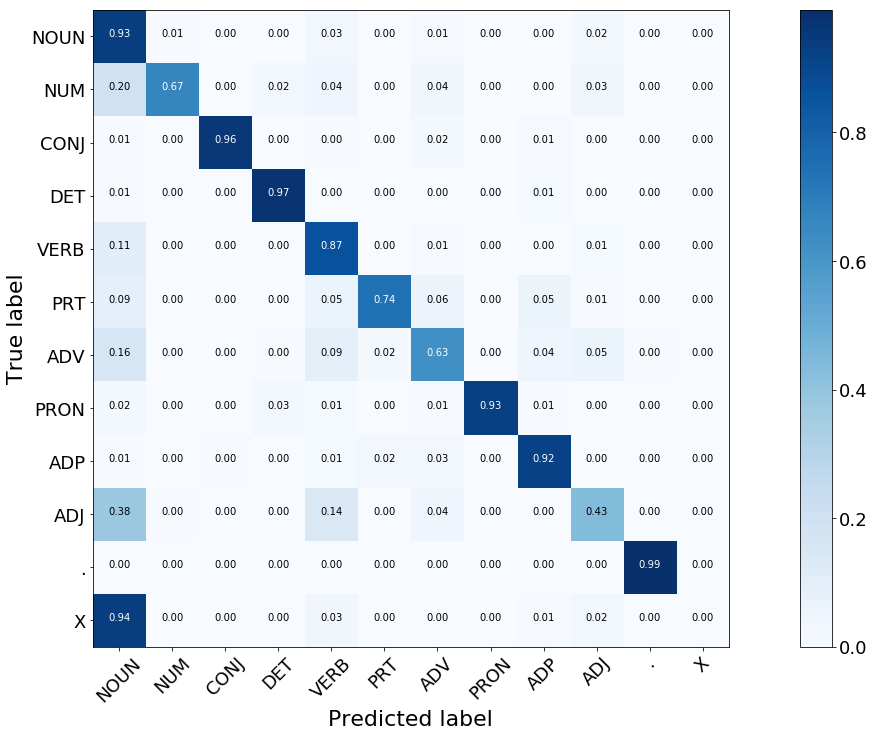

In [18]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=22)
    plt.xlabel('Predicted label', fontsize=22)

plot_confusion_matrix(cm, tags_plot,normalize=True)
plt.savefig('SVM_CM_{}_{}_train_sentences.png'.format(tag_set,len_train), bbox_inches="tight", transparent = True)

In [13]:


out = open('SVM_metrics_{}_{}_train_sentences.txt'.format(tag_set,len_train),'w')
#Calculate metrics for each label, and find their average, weighted by support 
#(the number of true instances for each label). 
#This alters ‘macro’ to account for label imbalance; it can result in an F-score 
#that is not between precision and recall.
out.write(" Accuracy: {}\n".format(metrics.accuracy_score(golds,SVM_tagger_pred_labels)))

#ability of the classifier not to label as positive a sample that is negative
out.write(" Precision: {}\n".format(metrics.precision_score(golds,SVM_tagger_pred_labels, average='weighted')))

#ability of the classifier to find all the positive samples.
out.write(" Recall: {}\n".format(metrics.recall_score(golds,SVM_tagger_pred_labels,average='weighted')))

out.write(" F1-Score: {}\n".format(metrics.f1_score(golds,SVM_tagger_pred_labels,average='weighted')))
out.close()

C:\Users\Matteo\Anaconda3\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Matteo\Anaconda3\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [14]:
hist = []
tags_plot = ['NOUN','NUM','CONJ','DET','VERB','PRT','ADV','PRON','ADP','ADJ','.','X']
for tag in tags_plot:
    hist.append([corr_dict.get(tag,0), wrong_dict.get(tag,0)])

C:\Users\Matteo\Anaconda3\envs\py35\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


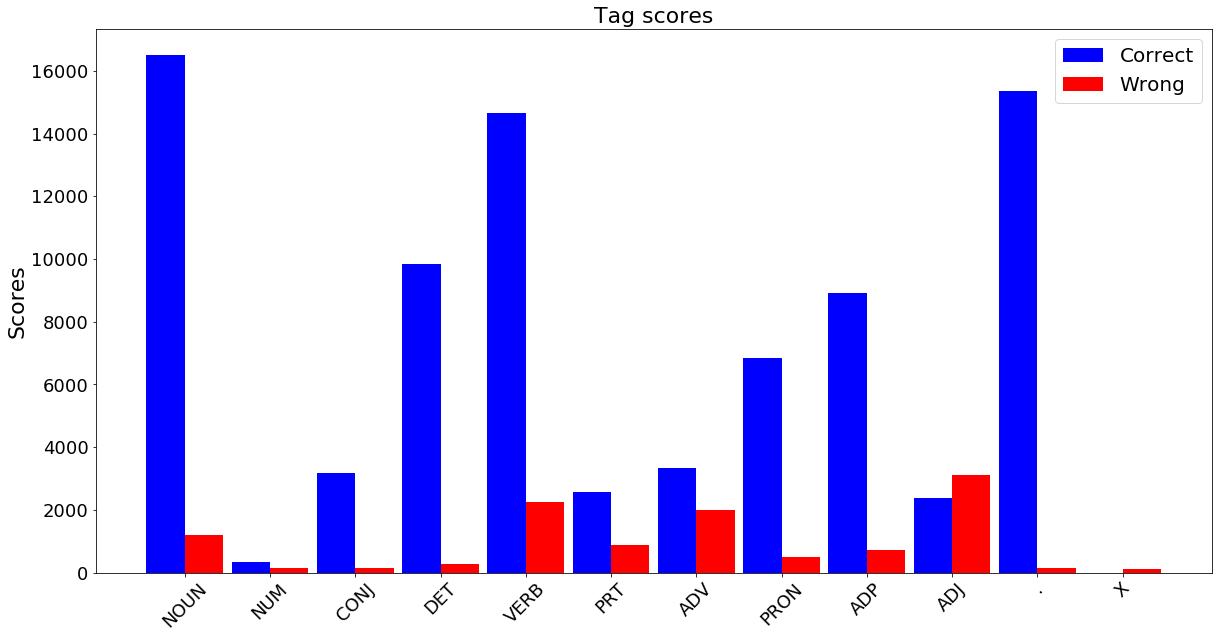

In [20]:
plt.clf()
x_labels = tags_plot
width = 0.45
fig, ax = plt.subplots()
range_bar1 = np.arange(len(x_labels))
rects1 = ax.bar(range_bar1, tuple(np.array(hist)[:,0]) , width, color='b')
rects2 = ax.bar(range_bar1 + width, tuple(np.array(hist)[:,1]) , width, color='r')

ax.set_ylabel('Scores',fontsize=22)
ax.set_title('Tag scores', fontsize=22)
ax.set_xticks(range_bar1 + width/2)
ax.set_xticklabels(x_labels)

ax.legend((rects1[0], rects2[0]), ('Correct', 'Wrong'),fontsize=20)
plt.legend()
plt.xticks(rotation=45)
plt.savefig('SVM_accuracy_bars_{}_{}_train_sentences.png'.format(tag_set,len_train),  bbox_inches="tight", transparent = True)
plt.show()